In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.patches as mpatches
import demo_func
import importlib as imp
imp.reload(demo_func)
from demo_func import DemoData, hierarchy_pos
import altair as alt
import os, sys
sys.path.insert(1, os.path.join(sys.path[0], '../..'))
alt.renderers.set_embed_options(actions=False)
import pandas as pd

In [2]:
signals_to_generate = 2000
network_cluster_count = 15
x_plot_labels = np.linspace(1, 1000, 1000)

demo = DemoData(
    no_signals=signals_to_generate, 
    seed=833142, 
    no_network_clusters = network_cluster_count
)

signals = demo.generate_raw_data()

impairments = {
            "Suckout" : (26, "green", 
                            np.arange(300,370), 0.5 * (np.abs(np.arange(-35, 35)) - 35)
                        ),
            "Wave" :    (24, "orange", 
                            np.arange(580,700), 3*np.sin(np.arange(120)/5)
                        ),
        }

tilt_x = np.arange(1000)
tilt_y = np.zeros(1000,)
tilt_y[demo.ideal_signal > 0] = -tilt_x[demo.ideal_signal > 0] * 0.02
impairments["Tilt"] = (18, "red", tilt_x, tilt_y)

graph, impaired_signals, network_clusters = demo.generate_impaired_graph(
    impairments=impairments
)

# Identifying root causes of signal anomalies in a network

In this notebook, idendrogram capabilities are used to illustrate how having an interactive dendrogram can useful in analysing hierarchical clustering results in a setting of detecting anomalies in a telecommunications network.

## FBC 101

Full-band-capture (FBC) is a spectrum analysis technology that allows capturing signal strength across the frequency spectrum at end-consumer devices. It is employed by telecommunications companies to remotely identify network impairment issues that may be impacting the quality of cable TV or internet for their customers. You can learn more about in a [great intro post by Ron Hranac](https://broadbandlibrary.com/full-band-capture-revisited/). 

Here's a quick visual introduction to FBC scans (x-axis is frequency (Hz), y-axis is signal strength (log(dB)).

A healthy FBC scan will look something like this - with signal present at certain frequencies and no signal at others (they could be reserved for other purposes - e.g. radio or simply not used by the provider), with a bit of noise everywhere.

In [3]:
h_signal = pd.DataFrame(
    {
    'log(dB)': signals[0,],
    'Hz': x_plot_labels
    }
)
alt.Chart(h_signal).mark_line().encode(
    x='Hz', y='log(dB)'
).properties(width=600, height=200, title='A healthy FBC scan')

alt.Chart(...)

Unfortunately, in real world, signals are often impaired at specific frequency ranges. Causes vary: physical cable damage, water, interference, equipment failure. Interestingly, impairments tend to produce certain "shapes" in the FBC scans. A few of them include:
 * Tilt (the signal gets linearly stronger / weaker across the spectrum)
 * Wave (a periodic turbulence in the signal level)
 * Suckout (a drop in a signal level in a narrow frequency range)

Here's how that may look visually.


In [4]:
samples = [{
        'title': 'Suckout impaired signal',
        'log(dB)': impaired_signals[network_clusters == 6,:][0],
        
    },
    {
        'title': 'Tilt & suckout impaired signal',
        'log(dB)': impaired_signals[network_clusters == 11,:][0],
        
    },
    {
        'title': 'Wave impaired signal',
        'log(dB)': impaired_signals[network_clusters == 5,:][0],
    }]

charts = []

for sample in samples:
    df = pd.DataFrame({
        'log(dB)': sample['log(dB)'],
        'Hz': x_plot_labels
    })
    charts.append(
        alt.Chart(df).mark_line().encode(
            x='Hz', y='log(dB)',
        ).properties(width=600, height=150, title=sample['title'])
    )

alt.vconcat(*charts)

alt.VConcatChart(...)

## Identifying root causes of impairments via clustering

A telecommunications network is - well - a *network*. It has a hierarchical structure, and impairments that impact upstream devices likely affect downstream devices, too. As a result, what one may observe in FBC scans are clusters of similarly looking patterns. That's exactly the strategy we will employ in this notebook to identify root causes - we'll cluster FBC scans, and work with the resulting dendrograms to identify the exact network node where the issue may be.

We use synthetically generated data in this case study. In total, we have 1000 individual nodes that fall into 12 network segments that are then connected via hierarchical structures. We'll assume that we don't have access to the data that describes the hierarchical structure of the network. 

In this hypothetical network, there are 3 sources of impairment:
 * Suckout, that's affecting nodes in the segments marked '0' and '5';
 * Tilt that's affecting nodes in the segments marked '7' and '11';
 * Wave that is higher upstream in the network and thus affects a number of segments, including the ones affected by tilt.



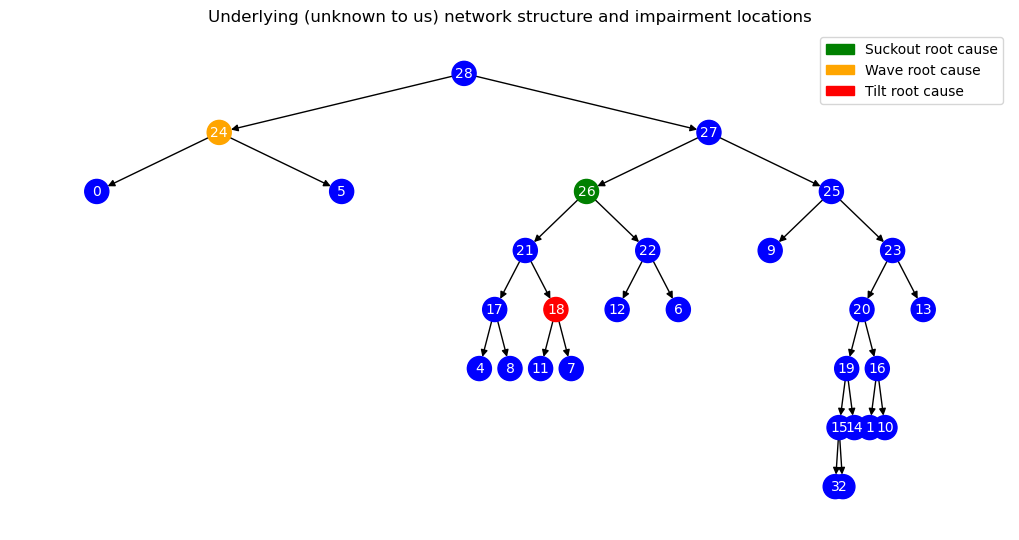

In [5]:
root_node_id = network_cluster_count * 2 - 2
pos = hierarchy_pos(graph,root=root_node_id)    
handles=[
    mpatches.Patch(color=color, label=f"{name} root cause") 
    for name, (_, color, _, _) in impairments.items()
]
fig = plt.figure(figsize=(10,5))
colors = list(nx.get_node_attributes(graph,'color').values())
nx.draw(
    graph, pos = pos, with_labels=True, 
    node_color = colors, font_size=10, font_color="white"
)
plt.legend(handles=handles)
plt.title("Underlying (unknown to us) network structure and impairment locations")
plt.show()

## Raw data

The raw data was generated previously (see the full notebook on GitHub if you're interested in the details). It is stored in a 2000 (nodes) x 1000 (signal strength at a given Hz level) numpy array.

In [6]:
print(impaired_signals.shape)
impaired_signals

(2000, 1000)


array([[-48.73758641, -50.16252451, -50.65304196, ..., -47.68256582,
        -51.1391094 , -50.3978072 ],
       [-50.6824544 , -51.00383931, -49.7139957 , ..., -51.22499804,
        -50.71977886, -50.65105806],
       [-51.25975866, -50.38603966, -50.81908226, ..., -50.76398726,
        -49.74155938, -51.38011933],
       ...,
       [-49.97342722, -50.84638163, -50.79542376, ..., -51.39005236,
        -50.12155185, -50.53228092],
       [-49.6501856 , -48.30615456, -49.67353999, ..., -49.78269459,
        -49.99977493, -48.95558339],
       [-50.2615207 , -50.18197952, -48.8535185 , ..., -50.56808448,
        -51.07097498, -51.58680055]])

## Clustering

Clustering this dataset in raw form is not the best idea: we have 1000 records, each of which has 1000 data points (i.e. 1000 dimensions). Instead, we will reduce its dimensionality using discrete wavelet transformation (DWT). I have written a [practical intro to DWT](https://intro-to-wavelets.streamlit.app/) a while ago in case you're interested in the details.

DWT allows us to reduce the size of the dataset by over 95% while still maintaining most of the information about the signal structures. Yes, it sounds a bit like magic - but it isn't, it's just a perfect tool for use cases like this. Not only it reduces the dimensionality of the data, but it should also help with reducing noise in it.

In [7]:
sparse_matrix = demo.get_sparse_wavelet_matrix(impaired_signals)
print(f"Number of non_zero entries: {sparse_matrix.count_nonzero()}")
print(f"Reduction in size: {(1 - (sparse_matrix.count_nonzero() / impaired_signals.size)):.4f}")

Number of non_zero entries: 93220
Reduction in size: 0.9534


Let's use HDBSCAN to cluster this data. Note that it takes less than a second to run - thanks to the dimensionality reduction performed previously. We seem to have 6 clusters.

In [8]:
import hdbscan
clusterer = hdbscan.HDBSCAN()
clusterer.fit(sparse_matrix)
print(f"Total clusters identified: {clusterer.labels_.max() + 1}")

Total clusters identified: 6


## Exploring the clustering results

HDBSCAN identified two large clusters (Cluster 0 with 1168 members and Cluster 1 with 543 members), while the remaining ones are smaller, and there are 2 FBC scans that were deemed as anomalous.

In [9]:
from collections import Counter
Counter(clusterer.labels_)

Counter({0: 1168, 1: 543, 2: 60, 4: 152, 3: 22, 5: 53, -1: 2})

Next, let's visualize the signal variation in the clusters identified. It looks like HDBSCAN got quite a few things right, but notably we don't have a single "clean signal" cluster. It has been merged into the wave cluster (Cluster 0).

In [10]:
cluster_summaries  = []

for cluster in range(clusterer.labels_.max()):    
    cluster_signals = impaired_signals[clusterer.labels_ == cluster, :]
    cluster_summaries.append(
        pd.DataFrame({
            'cluster': f"Cluster {cluster}",
            'avg': np.mean(cluster_signals, axis=0),
            'max': np.max(cluster_signals, axis=0),
            'min': np.min(cluster_signals, axis=0),
            'Hz': x_plot_labels
        })
    )

melted_summaries = pd.concat(cluster_summaries).melt(['cluster', 'Hz'])

alt.data_transformers.disable_max_rows()
alt.Chart(melted_summaries).mark_line().encode(
    alt.X("Hz"), alt.Y("value", title='log(dB)'), 
    alt.Color('variable', title='statistic'), alt.Row("cluster")
).properties(width=500, height=200)

alt.Chart(...)

At this point, you could go back and start tuning the algorithm hyperparameters or tweak DWH process. That's a valid route to go, but an alternative is to get a human expert in the loop and explore the results. Clustering algorithms are unlikely to give a "perfect" answer every time, but if their results are robust enough, they are invaluable to a human expert who may be otherwise plowing through this sort of data manually.

## Using idendrogram to get additional insights

Let's start by making a quick dendrogram that visualizes the last 10 merges that happen in the hierarchical process. We can see that cluster 0 is a result of two sub-cluster merges, one of which had 890 members and the other - 278.

In [11]:
import idendrogram

cl_data = idendrogram.HDBSCANClusteringData(clusterer)
idd = idendrogram.idendrogram()
idd.set_cluster_info(cluster_data=cl_data)

idd.create_dendrogram(truncate_mode='lastp', p=10).plot(
    backend="altair", width=600, height=300, 
    scale="symlog"
)

alt.LayerChart(...)

Let's see what happens "below" those two subclusters. Let's plot another dendrogram, but this time go deeper. We'll plot the dendrogram on the side so it fits easier. What we can see that HDBSCAN is very certain about these subclusters - even when we go deeper, the clusters split up by one item at a time, there are no merges of larger subclusters.

In [12]:
idd.create_dendrogram(truncate_mode='level', p=10).plot(
    backend="altair", width=500, height=800, 
    scale="symlog", orientation="right"
)

alt.LayerChart(...)

With that in mind, let's do a couple of tweaks to the dendrogram:
* To make it more focused, let's size the radii of each node by number of items in it;
* Let's modify the tooltips to include information about variability of the signal in each node;
* Let's add information about the network segments that the nodes belong to.

In [13]:
def my_custom_tooltip(data, linkage_id):
    _, nodelist = data.get_tree()
    original_ids = nodelist[linkage_id].pre_order(lambda x: x.id)
    signals = impaired_signals[original_ids, :]
    network_segments = np.unique(network_clusters[original_ids])    
    in_cluster_variability_std = np.quantile(np.std(signals, axis=0), [.25, .5, .75])
    in_cluster_variability_min_max = np.quantile(np.max(signals, axis=0) - np.min(signals, axis=0), [.25, .5, .75])

    diff_to_ideal = np.abs(signals - demo.ideal_signal.reshape(1, -1))

    return {        
        'items': str(nodelist[linkage_id].get_count()),         
        'In-cluster variability (std)': in_cluster_variability_std.round(2).tolist(),
        'In-cluster variability (min-max)': in_cluster_variability_min_max.round(2).tolist(),
        'Delta to ideal signal (MAE)': diff_to_ideal.sum(axis=1).mean().round(0),
        "Network segments": ", ".join([str(i) for i in network_segments]),        
    }

dendrogram = idd.create_dendrogram(
    truncate_mode='lastp', p=10, 
    leaf_label_func = lambda *_: "",
    node_hover_func= my_custom_tooltip
)

for n in dendrogram.nodes:
    obs_count = int(idendrogram.callbacks.counts(cl_data, n.id))
    n.radius = max(2, np.log2(obs_count ** 2))

dendrogram.plot(
    backend="altair", width=600, height=400, 
    scale="symlog", orientation="bottom"
)


alt.LayerChart(...)

Now it's easy to explore the dendrogram and see that cluster 2-5 all relate to the original network segments 7 & 11 - that's where the tilt & suckout impairment is present. Cluster 1 represents nodes affected by suckout, while Cluster 0 contained both healthy nodes and the nodes affected by the wave impairment. Going one level deeper, however, allows us to cleanly identify where the healthy nodes are. Now we can send technicians to investigate the network equipment these nodes share! 

Altair (or plotly) tooltips can be somewhat limiting though. In those cases, you may want to switch to the Streamlit component. See how these results can be displayed in Streamlit here.